/tmp/ipykernel_218307/1370952345.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  toClasses = lambda x: int(scale*(x - mint) + base)
/home/benewsl/HagstofanDatathon25/code/haghackvenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 6.8816 - val_loss: 6.9443
Epoch 2/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.4372 - val_loss: 7.7660
Epoch 3/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 4.5810 - val_loss: 12.0332
Epoch 4/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 3.7365 - val_loss: 10.6437
Epoch 5/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.6037 - val_loss: 10.4405
Epoch 6/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.1646 - val_loss: 15.9185
Epoch 7/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.8559 - val_loss: 12.7819
Epoch 8/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7106 - val_loss: 14.3212
Epoch 9/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.6167 - val_loss: 13.4619
Epoch 10/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.4305 - val_loss: 13.7918
Epoch 11/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.2522 - val_loss: 14.5403
Epoch 12/42
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - 

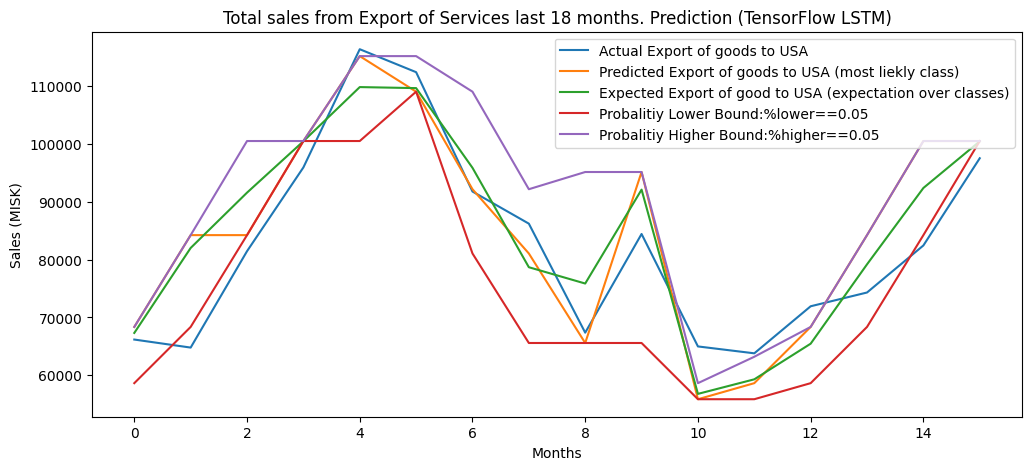

R-squared on the validation set: 0.7320
Weighted Absolute Percentage Error (WAPE): 7.6001
The LSTM model performace explains 73.1991% of the variance, with an average error (WAPE) of 7.6001%.
len USA goods 90


In [31]:
#Simple test code for a LSTM network using two data files in two runs:
#First file:  data1.txt (90 months 2018-2025 total export of services to 250 countries in FOB/MISK)
#Second file: data2.txt.(90 months 2018-2025 total export of goods to USA in Tonnes)

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.nn import softmax
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


#------------(HYPER)PARAMETERS-------------
LOOKBACK = 12
NUMCLASSES = 1000

EPOCHS = 42
BATCH_SIZE = 6

ALPHA = 0.1
# -----------Initialation and READ DATA Two different Real dataset are used:-------------------
# data1= Total sales of services MISK last 90 months,
# data3= Export of goods to USA in Tonnes last 90 months
# ---------------------------------------------------------------------------------------------
np.random.seed(42)
months = 90
t = np.arange(months)
numbers_list = []
numbers_list3 = []

# -------------------------
# Sequence maker function
# -------------------------
def make_sequences(X, y, LOOKBACK):
    Xs, ys = [], []
    for i in range(len(X) - LOOKBACK):
        #print(i,"\t", X[i:i+LOOKBACK])             # Commented out print statement
        Xs.append(X[i:i+LOOKBACK])
        ys.append(y[i+LOOKBACK])
    return np.array(Xs), np.array(ys)

# ------------------------------------------------------
# Calculates: Weighted Absolute Percentage Error (WAPE).
# Returns: The WAPE value as a float. Returns 0 if the
# sum of actual values is zero.
# ------------------------------------------------------
def calculate_wape(y_true, y_pred):
  y_true = np.array(y_true)                         # y_true: A numpy array or list of actual values.
  y_pred = np.array(y_pred)                         # y_pred: A numpy array or list of predicted values.

  # Avoid division by zero
  if np.sum(np.abs(y_true)) == 0:
    return 0
  else:
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# --------------------------------------
# Read the numbers from input data files
# --------------------------------------
def read_data():
  with open('data1_90 month_FOB_MISK_External trade in services, monthly 2018-2025.txt', 'r') as f:                 # data1.txt (export services total MISK) into a list
    for line in f:
      numbers_list.append(float(line.strip()))
  with open('data3_90 months_Tonnes_USA_UTA06102_2018-2025_20250905-103404.txt', 'r') as f:                 # data3.txt (USA export total Tonnes of goods) into a list
    for line in f:
      numbers_list3.append(float(line.strip()))
  data_array1 = np.array(numbers_list)
  data_array3 = np.array(numbers_list3)
  sales= data_array1                                # NOTE: Swithced files between data_array1 data_array3 depending on sales in MIS or Goods to USA in Tonnes
  return sales

def main():
  sales= read_data()
  features = np.stack([sales], axis=1)              # Generate feature data set & data processing
  targets = sales.reshape(-1, 1)
  f_mean, f_std = features.mean(0), features.std(0) # Normalize data
  features_n = (features - f_mean) / f_std


  #"Classify" targets
  RANGEMULT = 2
  mint = min(targets)
  maxt = max(targets)
  rng = (maxt - mint)

  scale = (NUMCLASSES/(RANGEMULT*rng))
  descale = (RANGEMULT*rng)/NUMCLASSES
  base = NUMCLASSES*((RANGEMULT -1)/(2*RANGEMULT))

  toClasses = lambda x: int(scale*(x - mint) + base)
  fromClasses = lambda y: mint + descale*(y - base)

  targets_c = np.array(list(map(toClasses, targets)))

  X, y = make_sequences(features_n, targets_c, LOOKBACK)
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

  

  # ----------------------------------------------
  # Model. Hyperparameters (LSTM, Dense)
  # ----------------------------------------------
  model = Sequential()
  model.add(LSTM(NUMCLASSES, input_shape=(LOOKBACK, X.shape[2])))
  model.add(Dense(NUMCLASSES, activation='relu'))
  model.add(Dense(NUMCLASSES))
  loss = SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer='adam', loss=loss)

  # ----------------------------------------------
  # Training. Hyperparameters (epochs, batch_size)
  # ----------------------------------------------
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

  # ---------------------------
  # Plot predictions vs actual
  # ---------------------------
  y_true = np.array(list(map(fromClasses, y_val)))
  y_hat = model.predict(X_val)
  y_pred = []
  for ylogits in y_hat:
    y_pred_class = np.argmax(ylogits)
    y_pred.append(fromClasses(y_pred_class))
  y_exp = []
  for ylogits in y_hat:
    yp = softmax(ylogits)
    y_exp_class = sum(yp*np.arange(NUMCLASSES))
    y_exp_val = fromClasses(y_exp_class)
    y_exp.append(y_exp_val)
  y_low = []
  for ylogits in y_hat:
    yp = softmax(ylogits)
    prob_running = 0
    l = int(tf.size(yp))
    for c in range(l):
      prob_running+=yp[c]
      if(prob_running>ALPHA/2):
        y_low.append(fromClasses(c))
        break
  y_high = []
  for ylogits in y_hat:
    yp = softmax(ylogits)
    prob_running = 0
    l = int(tf.size(yp))
    for c in range(l-1, -1, -1):
      prob_running+=yp[c]
      if(prob_running>ALPHA/2):
        y_high.append(fromClasses(c))
        break



  plt.figure(figsize=(12,5))
  plt.plot(y_true, label="Actual Export of goods to USA")
  plt.plot(y_pred, label="Predicted Export of goods to USA (most liekly class)")
  plt.plot(y_exp, label="Expected Export of good to USA (expectation over classes)")
  plt.plot(y_low, label=("Probalitiy Lower Bound:"+'%'+"lower=="+str(ALPHA/2)))
  plt.plot(y_high, label=("Probalitiy Higher Bound:"+'%'+"higher=="+str(ALPHA/2)))
  plt.title("Total sales from Export of Services last 18 months. Prediction (TensorFlow LSTM)")
  plt.xlabel("Months")
  plt.ylabel("Sales (MISK)")
  plt.legend()
  plt.show()

  # --------------------------------------------------
  # Calculate accurency: R-squared and WAPE
  # --------------------------------------------------
  r2 = r2_score(y_true, y_pred)                           # Calculate R-squared
  wape= calculate_wape(y_true, y_pred)                    # Calculate WAPE
  accurency= (100 - wape)                                 # Calculate Accurecy
  print(f"R-squared on the validation set: {r2:.4f}")
  print(f"Weighted Absolute Percentage Error (WAPE): {wape:.4f}")
  print(f'The LSTM model performace explains {r2*100:.4f}% of the variance, with an average error (WAPE) of {wape:.4f}%.')
  print("len USA goods",len(sales))                       # Check input features array sices
  return targets_c, model, X_train, y_val, y_pred, targets
                                                          # make these varaibale global for the second programming cell
if __name__== "__main__":
  targets_c, model, X_train, y_val, y_pred, targets = main()

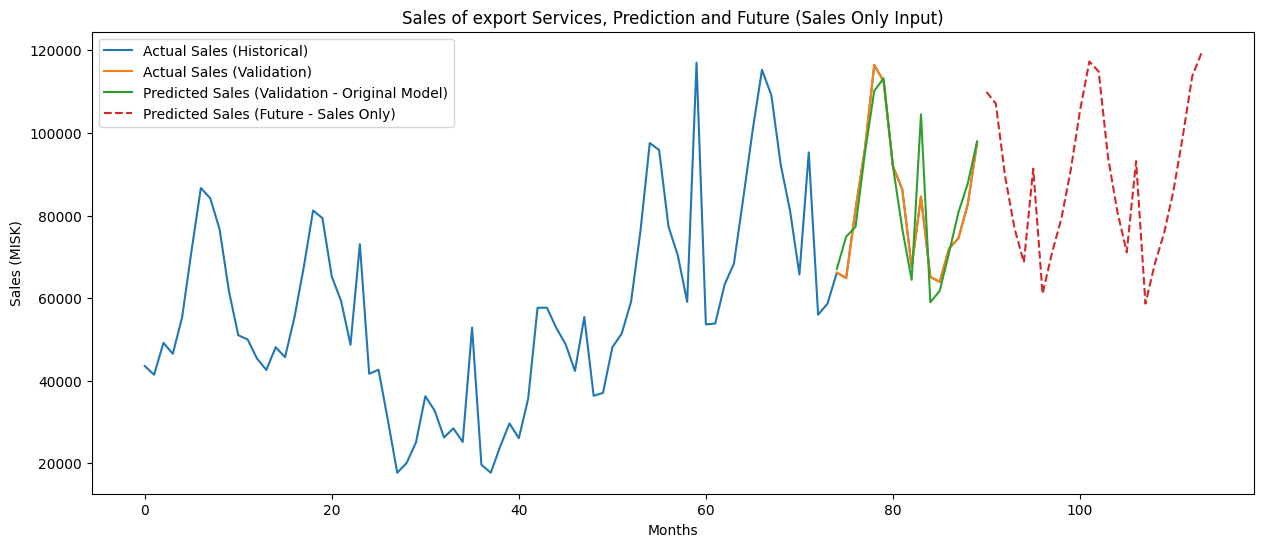

Future Export of services to 250 countries Predictions (next 24 months - Sales Only):
[109948.78724997 107125.0763247   89428.65217323  76892.26572
  68639.68605808  91361.14636289  61061.80199232  70907.21972158
  79179.59517028  90852.38217413 105383.6485166  117296.49335711
 114894.0960371   94059.73383352  80929.40043214  71103.44078226
  93177.94338364  58677.0614011   68307.38968325  75808.73720655
  86071.70920271  99281.45898795 113695.48205114 119433.77529102]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Plot future predictions using only sales data
# ---------------------------------------------------
def plotting(validation_months_indices,future_months_indices_sales_only, future_predictions_sales_only, targets, y_val, y_pred, y_std, y_mean ):
  try:
    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(targets)), targets, label="Actual Sales (Historical)")
    plt.plot(validation_months_indices, y_val * y_std + y_mean, label="Actual Sales (Validation)")
    plt.plot(validation_months_indices, y_pred, label="Predicted Sales (Validation - Original Model)")                # Using y_pred from the first cell
    plt.plot(future_months_indices_sales_only, future_predictions_sales_only, label="Predicted Sales (Future - Sales Only)", linestyle='--')
    plt.title("Sales of export Services, Prediction and Future (Sales Only Input)")
    plt.xlabel("Months")
    plt.ylabel("Sales (MISK)")
    plt.legend()
    plt.show()
  except Exception as e:
    print(f"Error in plotting: {e}")

# -------------------------------------------------------
# Predict future sales using only historical sales data
# -------------------------------------------------------
def main(targets_n, y_std, y_mean, model, X_train, y_val, y_pred, targets):                                           # Call the main function from the previous cell to get the variables
                                                                                                                      # The variables are now passed as arguments to this main function
  last_sales_sequence_n = targets_n[-lookback:]                                                                       # Get the last 'lookback' data points from the normalized historical sales data
  future_predictions_sales_only_n = []                                                                                # List to store future normalized predictions
  num_future_months = 24
  try:                                                                                                                # Number of months to predict into the future
    current_sales_sequence_n = last_sales_sequence_n.copy()                                                           # Initialize the current sequence for prediction
    for i in range(num_future_months):                                                                                # Reshape the current sequence to match the model's input shape (1, lookback, num_features)
      input_sequence = current_sales_sequence_n.reshape(1, lookback, 1)                                               # Since we only have one feature (sales or goods), the shape is (1, lookback, 1)
      next_sales_n = model.predict(input_sequence, verbose=0)                                                         # Predict the next sales value (normalized). verbose=0 to reduce output during prediction
      future_predictions_sales_only_n.append(next_sales_n[0, 0])                                                      # Append the predicted sales to the future predictions list
      current_sales_sequence_n = np.roll(current_sales_sequence_n, -1)                                                # Update the current sequence by removing the first value and adding the predicted value
      current_sales_sequence_n[-1] = next_sales_n[0, 0]
    future_predictions_sales_only = np.array(future_predictions_sales_only_n) * y_std + y_mean                        # Denormalize the future predictions
    last_historical_month = len(targets)                                                                              # Calculate the time indices for the future predictions
    future_months_indices_sales_only = np.arange(last_historical_month, last_historical_month + num_future_months)
    start_index_validation = lookback + len(X_train)                                                                  # Calculate the time indices for the validation data (copied from the previous cell for plotting)
    validation_months_indices = np.arange(start_index_validation, start_index_validation + len(y_val))
  except Exception as e:
    print(f"Error in predicting future sales using only historical sales data: {e}")

  plotting(validation_months_indices,future_months_indices_sales_only,future_predictions_sales_only, targets, y_val, y_pred, y_std, y_mean )
  print("Future Export of services to 250 countries Predictions (next {} months - Sales Only):".format(num_future_months))
  print(future_predictions_sales_only)
main(targets_n, y_std, y_mean, model, X_train, y_val, y_pred, targets)                                                # Call the main function from the previous cell and pass its return values to the second main function
                                                                                                                      # Assuming the first cell has been executed and its variables are in the global scope